# AI 18 박경훈 Section4 Proejct
* 작업순서
    1. 영화 정보를 입력하여 관객수를 예측하는 모델을 배포
    2. 영화진흥위원회 API 사용, 네이버영화에서 관객평점을 동적스크래핑
    3. PostgreSQL로 저장후 간단한 모델피팅
    4. Flask로 api작성하여 서버에서 모델활용
    5. Flask에 대시보드 연결

## 영화진흥위원회 API를 통한 수집
* API를 통해 박스오피스 10위권 이내의 영화들 정보 수집
    * 영화고유코드, 영화이름, 개봉일자, 누적관객수, 상영시간, 국가, 장르, 감독, 배우, 관람등급, 제작사 정보포함
    * 해당 정보를 pandas DataFrame으로 저장
* API 하루 제한 : 3000회


In [1]:
from datetime import datetime, timedelta
from tqdm import tqdm
import time
import json
import os
import gc

import matplotlib.pyplot as plt

import pandas as pd
import requests

import subprocess
import psycopg2
from psycopg2.extras import execute_values


# 영화산업진흥회 API_KEY
API_KEY = 'd08e22ff6f15e7dedd7f2d48a2bc6296'

# BASE_URL : 주간 박스오피스 URL
# BASE_URL2 : 영화 상세정보 URL
BASE_URL = 'http://www.kobis.or.kr/kobisopenapi/webservice/rest/boxoffice/searchWeeklyBoxOfficeList.json'
BASE_URL2 = 'http://www.kobis.or.kr/kobisopenapi/webservice/rest/movie/searchMovieInfo.json'
api_params = {'key': API_KEY, # key
              'weekGb': '0', # 월~일 전부 포함
              'targetDt': None, # 특정일 선택(YYYYmmdd)
              'multiMovieYn': 'N'} # 상업영화만 포함

api_params2 = {'key': API_KEY,
               'movieCd': None} # 영화고유번호

In [26]:
# 현재일로부터 약 10년간의 주간 박스오피스 확인
# 1년 = 52주 => 10년 = 520주
def get_boxoffice_data(weeks=520):
    """
    weeks를 받아서 현재날짜 -1 주차부터 (현재 - weeks)주차까지 주간박스오피스 정보받아오기

    args:
        weeks : 현재로부터 몇주전까지 살펴볼건지

    returns: Pd.DataFrame
        movieCd : 영화고유코드
        movieNm : 영화이름(국문)
        openDt : 개봉일자 (YYYY-mm-dd)
        audiAcc : 누적관객수
    """
    date_now = datetime.now().date()
    weeks = [(date_now - timedelta(weeks=i)).strftime("%Y%m%d") for i in range(1,weeks+1)]
    df = pd.DataFrame()

    for i in tqdm(weeks, position=0, leave=True):
        api_params['targetDt'] = i
        time.sleep(0.1)
        response = requests.get(BASE_URL, params=api_params)
        if response.status_code != 200:
            print(f"{i}일자 오류 발생 : {response.status_code}")
            continue
        else:
            result = response.json()
            result = result['boxOfficeResult']['weeklyBoxOfficeList']
            columns = ['movieCd','movieNm','openDt','audiAcc']
            # 필요한 key(column)만 남기기
            result =  [{key : i[key] for key in columns} for i in result]
            # df에 추가
            df = pd.concat([df, pd.DataFrame.from_dict(result)])
    # movieCd, audiAcc기반으로 정렬 및 중복제거
    df['audiAcc'] = df['audiAcc'].astype(int)
    df = df.sort_values(by=['movieCd', 'audiAcc'], ascending=False)
    df.drop_duplicates(subset='movieCd', keep='first', inplace=True)
    df.audiAcc = df.audiAcc.astype('uint32')
    df.reset_index(drop=True, inplace=True)

    return df


df = get_boxoffice_data()
# record(영화) 약 1500개

100%|██████████| 519/519 [07:18<00:00,  1.18it/s]


In [60]:
# boxoffice data 받아서 영화코드(movieCd)에 맞는 상세정보 불러오기
#########################################################################
def get_detail_data(df):
    """
    get_boxoffice_data의 결과를 받아 영화의 상세정보를 추가하여 리턴

    args:
        df : input dataframe
    returns: DataFrame
        movieCd : 영화고유코드
        movieNmEn : 영화이름(영문)
        showTm : 상영시간
        nations : 제작국가
        genres['genreNm'] : 대표장르 2개
        directors[0]['peopleNm'] : 감독이름 (국문)
        actors : 대표배우 (최대 3명)
        audits[0]['watchGradeNm'] : 관람등급
        companys[0]['companyCd' & 'companyNm'] : 참여회사코드, 이름(국문)
    """
    def list_cut(ls:list, length:int):
        """정해진 길이만큼 리스트 패딩. (None으로 패딩)"""
        if len(ls) >= length:
            return ls[:length]
        else:
            return ls + [None] * (length - len(ls))


    movieCd_list = df.movieCd.to_list()
    df2 = []

    for movieCd in tqdm(movieCd_list, position=0, leave=True):
        api_params2['movieCd'] = movieCd
        time.sleep(0.1)
        response = requests.get(BASE_URL2, params=api_params2)
        single_row = [movieCd]
        if response.status_code != 200:
            print(f"영화코드 {movieCd} 오류 발생 : {response.status_code}")
            continue
        else:
            result = response.json()
            result = result['movieInfoResult']['movieInfo']
            
            # 필요한정보만 담은 리스트로 가공
            # 순서 : movieCd, movieNmEn, showTm, nations, genres1, genres2, director,
            #       actors1, actors2, actors3, audit, companyCd, companyNm
            # 13개 columns
            single_row.append(result['movieNmEn'] if bool(result['movieNmEn']) else None)
            single_row.append(int(result['showTm'] if bool(result['showTm']) else 0))
            single_row.append(result['nations'][0]['nationNm'] if bool(result['nations']) else None)
            # 장르 2개까지, 2개미만이면 나머지 None
            single_row.extend(
                list_cut([i['genreNm'] for i in result['genres']],
                         length=2)
            )
            single_row.append(result['directors'][0]['peopleNm'] if bool(result['directors']) else None)
            # 배우 3명까지, 3개 미만이면 나머지 None
            single_row.extend(
                list_cut([i['peopleNm'] for i in result['actors']],
                         length=3)
            )
            single_row.append(result['audits'][0]['watchGradeNm'] if bool(result['audits']) else None)
            single_row.append(result['companys'][0]['companyCd'] if bool(result['companys']) else None)
            single_row.append(result['companys'][0]['companyNm'] if bool(result['companys']) else None)
            assert len(single_row)==13, f"record 길이 다름. 필요: 13, input : {len(single_row)}"

        df2.append(single_row)
    column_names = ['movieCd', 'movieNmEn', 'showTm', 'nations', 'genres1', 'genres2',\
                    'director', 'actors1', 'actors2', 'actors3', 'audit','companyCd', 'companyNm']
    df2 = pd.DataFrame(df2, columns=column_names)
    df2 = pd.merge(df, df2, on='movieCd', how='inner')
    df2.showTm = df2.showTm.astype('uint16')
    return df2
#########################################################################


df2 = get_detail_data(df)

100%|██████████| 1500/1500 [10:27<00:00,  2.39it/s]


* api 횟수제한으로 인해 사용불가할때를 대비하여, 정보저장 및 불러오기

In [3]:
# ctrl + / 로 해제하여 사용

# df2.to_csv('to_db.csv', index=False, encoding='utf-8') # 저장
# df2 = pd.read_csv('to_db.csv', encoding='utf-8') # 불러오기

## 셀레니움 활용 동적스크래핑
* 크롬드라이버 활용
    * 크롬 버전 : 114.0.5735.134
    * 드라이버 버전 : 114.0.5735.90
* 네이버영화 관람객 평점만 스크래핑

In [36]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

#########################################################################
def get_movie_rating(df):
    """
    selenium으로 df의 영화이름별 평점 검색하여 추가
    
    args:
        df : input dataframe
    returns:
        rating_df : dataframe with ratings
    """
    # 평점 element xpath
    RATING_XPATH = '//*[@id="main_pack"]/div[2]/div[2]/div[1]/div/div[2]/div/div/ul/li[1]/div/div[1]/span[1]'
    RATING_XPATH2 = '//*[@id="main_pack"]/div[2]/div[2]/div/div[2]/div[2]/dl/div[3]/dd' # 대체 XPATH
    driver = webdriver.Chrome()
    driver.get(r"https://search.naver.com/search.naver")
    driver.implicitly_wait(5) # 웹페이지 로딩까지 최대 5초 대기
    time.sleep(1)
    
    rating_df = [] # form : [single_row1, single_row2, ...]
    for i, row in df.iterrows():
        movieCd = row.movieCd # 영화 고유번호
        movieNm = row.movieNm # 영화 이름
        single_row = [movieCd] # form : [movieCd, rating]

        query_elem = driver.find_element(by=By.ID, value='nx_query')
        query_elem.clear()
        query_elem.send_keys(f"영화 {movieNm} 평점")
        query_elem.send_keys(Keys.RETURN)
        
        # 평점 element로딩까지 최대 3초 기다리고 수집
        try:
            rating = WebDriverWait(driver, 3).until(
                EC.presence_of_element_located((By.XPATH, RATING_XPATH))
            ).text
        except: # 일반적인 영화평점창이 안나올경우
            try:
                rating = driver.find_element(By.XPATH, RATING_XPATH2).text
            except:
                rating = float('nan')
        single_row.append(rating)
        rating_df.append(single_row)
        time.sleep(2)
    
    driver.close()
    rating_df = pd.DataFrame(rating_df, columns=['movieCd', 'rating'])
    rating_df = pd.merge(df, rating_df, on='movieCd', how='inner')
    return rating_df
#########################################################################

df3 = get_movie_rating(df2)


In [168]:
# 마찬가지로 저장 및 불러오기

# df3.to_csv('to_db.csv', index=False, encoding='utf-8')
# df3 = pd.read_csv('to_db.csv', encoding='utf-8')


## DB 저장
* 도커로 psql db 컨테이너 생성(프로젝트 내의 폴더와 마운트)
* 이후 스키마에 맞춰 테이블 생성(처음만)
* 스키마에 맞춰 수집한 데이터 전달

DB 컨테이너 실행 및 연결

In [140]:
# 도커 컨테이너 시작 및 db생성, psycopg2로 연결
#########################################################################
def init_db():
    """
    도커 컨테이너를 실행하고, movie_db 데이터베이스를 만들고, connection과 cursor객체를 반납하는 함수.
    
    returns:
        conn : connection 객체
        cursor : cursor 객체
    """

    # psql db 컨테이너 생성. 포트5432, 마운트 postgresDB:/var/lib/postgresql/data
    DB_PATH = os.path.join(os.getcwd(), 'postgresDB')
    PSQL = f"-d -p 5432:5432 --name db -e POSTGRES_PASSWORD=ai18khp -v {DB_PATH}:/var/lib/postgresql/data postgres"

    # 도커 db 컨테이너 없을시(혹은 실행중이 아닐시) 실행
    quote = r"docker ps -a --format {{.Names}}"
    container_list = subprocess.check_output(quote, shell=True).decode().split()
    if 'db' not in container_list:
        !docker run $PSQL
    else:
        !docker start db
    time.sleep(1)

    # 컨테이너 내부 db에 movie_db 없을시 생성
    quote = r'docker exec db psql -U postgres -c "SELECT datname FROM pg_database;"'
    database_list = subprocess.check_output(quote, shell=True).decode().split()
    if 'movie_db' not in database_list:
        !docker exec db psql -U postgres -c "CREATE DATABASE MOVIE_DB;"

    conn = psycopg2.connect(host="localhost",
                        dbname='movie_db',
                        user='postgres',
                        password='ai18khp',
                        port=5432)
    cursor = conn.cursor()
    
    return conn, cursor
#########################################################################


conn, cursor = init_db()

db


스키마 생성

In [109]:
# 스키마 생성
#########################################################################
def create_schema(conn, cursor):
    """
    스키마를 생성하는 함수
    
    args:
        conn : connection 객체
        cursor : cursor 객체
    """
    cursor.execute("BEGIN") # 스키마생성 트랜잭션 시작
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS movie_info(
    movieCd CHAR(8) NOT NULL PRIMARY KEY,
    showTm INTEGER,
    openDt DATE,
    audiAcc INTEGER,
    rating REAL,
    nations VARCHAR(10),
    director VARCHAR(20),
    audit VARCHAR(30)
    )
    """)

    cursor.execute("""
    CREATE TABLE IF NOT EXISTS movie_name(
    movieCd CHAR(8) NOT NULL PRIMARY KEY,
    movieNm VARCHAR(100),
    movieNmEn VARCHAR(100),
    CONSTRAINT "name_fkey" FOREIGN KEY (movieCd) REFERENCES movie_info(movieCd)
        ON DELETE CASCADE
    )
    """)

    cursor.execute("""
    CREATE TABLE IF NOT EXISTS movie_genre(
    movieCd CHAR(8) NOT NULL PRIMARY KEY,
    genre1 VARCHAR(10),
    genre2 VARCHAR(10),
    CONSTRAINT "genre_fkey" FOREIGN KEY (movieCd) REFERENCES movie_info(movieCd)
        ON DELETE CASCADE
    )
    """)

    cursor.execute("""
    CREATE TABLE IF NOT EXISTS movie_actor(
    movieCd CHAR(8) NOT NULL PRIMARY KEY,
    actor1 VARCHAR(20),
    actor2 VARCHAR(20),
    actor3 VARCHAR(20),
    CONSTRAINT "actor_fkey" FOREIGN KEY (movieCd) REFERENCES movie_info(movieCd)
        ON DELETE CASCADE
    )
    """)
    cursor.execute("COMMIT") # 트랜잭션 커밋
#########################################################################


create_schema(conn, cursor)

**생성된 스키마**  


![](schema.png)

In [179]:
# 데이터베이스에 데이터 저장
#########################################################################
def db_bulk_insert(conn, cursor, df):
    """
    많은 자료를 한꺼번에 넣는 함수
    
    args:
        conn : connection 객체
        cursor : cursor 객체
        df : 넣고자하는 pandas DataFrame
    """

    # movie_info table INSERT, movieCd 충돌시 업데이트
    try:
        cursor.execute("BEGIN") #트랜잭션 시작

        temp = df3[['movieCd', 'showTm', 'openDt', 'audiAcc', 'rating', 'nations', 'director', 'audit']]
        query = [list(row) for row in temp.itertuples(index=False)]
        quote = """
        INSERT INTO movie_info VALUES %s
        ON CONFLICT (movieCd) DO UPDATE
        SET showTm = EXCLUDED.showTm, openDt = EXCLUDED.openDt,
            audiAcc = EXCLUDED.audiAcc, rating = EXCLUDED.rating,
            nations = EXCLUDED.nations, director = EXCLUDED.director,
            audit = EXCLUDED.audit
        """
        execute_values(cursor, quote, query)

        # movie_name table INSERT, movieCd 충돌시 업데이트
        temp = df3[['movieCd', 'movieNm', 'movieNmEn']]
        query = [list(row) for row in temp.itertuples(index=False)]
        quote = """
        INSERT INTO movie_name VALUES %s
        ON CONFLICT (movieCd) DO UPDATE
        SET movieNm = EXCLUDED.movieNm, movieNmEn = EXCLUDED.movieNmEn
        """
        execute_values(cursor, quote, query)

        # movie_genre table INSERT, movieCd 충돌시 업데이트
        temp = df3[['movieCd', 'genres1', 'genres2']]
        query = [list(row) for row in temp.itertuples(index=False)]
        quote = """
        INSERT INTO movie_genre VALUES %s
        ON CONFLICT (movieCd) DO UPDATE
        SET genre1 = EXCLUDED.genre1, genre2 = EXCLUDED.genre2
        """
        execute_values(cursor, quote, query)

        # movie_actor table INSERT, movieCd 충돌시 업데이트
        temp = df3[['movieCd', 'actors1', 'actors2', 'actors3']]
        query = [list(row) for row in temp.itertuples(index=False)]
        quote = """
        INSERT INTO movie_actor VALUES %s
        ON CONFLICT (movieCd) DO UPDATE
        SET actor1 = EXCLUDED.actor1, actor2 = EXCLUDED.actor2,
            actor3 = EXCLUDED.actor3
        """
        execute_values(cursor, quote, query)
        
        cursor.execute("COMMIT") #트랜잭션 끝
        print("Bulk INSERT 성공")
    except Exception as e:
        cursor.execute("ROLLBACK") # 오류발생시 롤백
        print("트랜잭션 오류 발생되어 취소됨.")
        print(f"오류 내용 : {e}")

    conn.commit()
#########################################################################


db_bulk_insert(conn, cursor, df3)

Bulk INSERT 성공


## DB에서 데이터 불러오기
* 원본 df3 삭제하고 데이터 불러오기
* 모델학습에 필요한 데이터만 호출

In [139]:
# 기존 구성했던 df3 삭제
try:
    del df3
except:
    pass
finally:
    gc.collect()

# SQL로 데이터 불러오기
# 모델 학습에 필요한 X, y
# X : showTm, OpenDt, rating, nations, audit, director, genre1, actor1, actor2, actor3 (10개)
# y : audiAcc

#########################################################################
def db_bulk_load(conn, cursor):
    """
    학습에 필요한 데이터를 전부 불러와서 X, y로 나눠주는 함수

    args:
        conn : connection 객체
        cursor : cursor 객체
    
    returns:
        X : features
        y : target (audiAcc)
    """
    cursor.execute("""
    SELECT audiAcc, showTm, openDt, rating, nations, audit, director, g.genre1, a.actor1, a.actor2, a.actor3
    FROM movie_info m
    JOIN movie_genre g ON m.movieCd = g.movieCd
    JOIN movie_actor a on m.movieCd = a.movieCd;
    """)
    col_name = ['audiAcc', 'showTm', 'openDt', 'rating', 'nations',\
                'audit', 'director', 'genre1', 'actor1', 'actor2', 'actor3']
    df = pd.DataFrame(cursor.fetchall(), columns=col_name)

    y = df.audiAcc.copy()
    X = df.drop(columns='audiAcc').copy()

    return X, y
#########################################################################

X, y = db_bulk_load(conn, cursor)

# db연결종료
if conn.closed == 0:
    conn.close()

X.head(5)



,showTm,openDt,rating,nations,audit,director,genre1,actor1,actor2,actor3
0,103,2023-02-01,9.66,한국,전체관람가,오윤동,공연,김남준,김석진,민윤기
1,110,2023-02-22,8.32,미국,12세이상관람가,니콜라스 D 존슨,미스터리,스톰 리드,켄 렁,다니엘 헤니
2,126,2023-06-06,7.22,미국,12세이상관람가,스티븐 카플 주니어,액션,안소니 라모스,피터 딘클리지,NaN
3,135,2023-05-24,6.46,미국,전체관람가,롭 마샬,뮤지컬,멜리사 맥카시,하비에르 바르뎀,아콰피나
4,124,2023-05-24,7.91,일본,12세이상관람가,후지이 미치히토,멜로/로맨스,고마츠 나나,사카구치 켄타로,NaN


## 모델학습
* 해당 프로젝트에서 중요한내용도 아니고, 시간도 없는관계로 간단하게
* openDt는 epoch time(월 기준) 으로 변경
* 범주형 컬럼 7개는 xgboost를 쓰는관계로 그냥 오디널 인코딩 이후 진행
* 모델은 XGboost Regressor

In [88]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from datetime import date
import numpy as np
from xgboost import XGBRegressor


def preprocess(X, y):
    """
    데이터 전처리 해주는 함수

    args:
        X : features
        y : target
    
    returns:
        X_train, X_test : preprocessed features
        y_train, y_test : target
    """

    # openDt는 epoch time으로 변환 (결측치는 nan으로)
    X.openDt = X.openDt.apply(
        lambda x: (x-date(1970,1,1)).total_seconds() if isinstance(x, date) else float('nan')
        )
    cat_cols = ['nations', 'audit', 'director', 'genre1', 'actor1', 'actor2', 'actor3']

    # 'NaN'을 ''으로 변환
    X[cat_cols] = X[cat_cols].apply(lambda x: x.replace('NaN', ''))

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        random_state=42)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocess(X, y)

oe = OrdinalEncoder(handle_unknown='use_encoded_value',
                    unknown_value=np.nan)
oe.set_output(transform='pandas')
cat_cols = ['nations', 'audit', 'director', 'genre1', 'actor1', 'actor2', 'actor3']
X_train[cat_cols] = oe.fit_transform(X_train[cat_cols])
X_test[cat_cols] = oe.transform(X_test[cat_cols])

In [86]:
model = XGBRegressor(n_estimators=1000,
                     max_depth=10,
                     learning_rate=0.01,
                     booster='gbtree',
                     colsample_bytree=0.7,
                     reg_alpha=1,
                     eval_metric='mae',
                     early_stopping_rounds=30,
                     n_jobs=-1)

model.fit(X_train, y_train,
          eval_set = [(X_test, y_test)],
          verbose=0)
''

''


      MAE  : 770615.37
      MAPE : 7.007


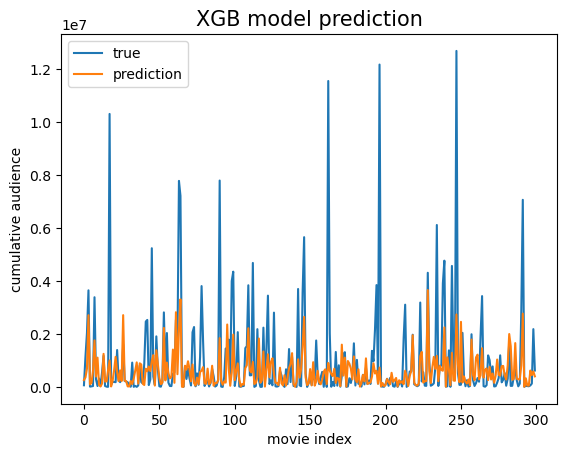

In [89]:
pred = model.predict(X_test)

mae = mean_absolute_error(y_test, pred)
mape = mean_absolute_percentage_error(y_test, pred)

print(f"""
      MAE  : {mae.round(3)}
      MAPE : {mape.round(3)}""")

plt.plot(y_test.to_list(), label='true')
plt.plot(model.predict(X_test), label='prediction')
plt.legend()
plt.title("XGB model prediction", fontsize=15)
plt.ylabel('cumulative audience')
plt.xlabel('movie index')
plt.show()

**모델 학습 결과**
* 누적관객수 MAE 약 70만, MAPE 약 7% 정도  

* 경향성은 대충 잘 추종하지만 4백만을 넘는 작품들의 값은 잘따라가지 못한다.  
=> **모델의 성능은 별로지만 시간이 없으므로 해당 모델 사용**

In [93]:
import joblib

# 모델 및 인코더 저장
joblib.dump(model, 'model.pkl')
joblib.dump(oe, 'encoder.pkl')

['encoder.pkl']

## METABASE 구동
* 이후부턴 Flask에서 확인

In [218]:
VOLUME_PATH = r'C:\Users\dynam\Desktop\AIB\Section4_project\metabase:/metabase-data'
QUOTE = 'docker run -d \
    -p 3000:3000 \
    -e "MB_DB_TYPE=postgres" \
    -e "MB_DB_DBNAME=movie_db" \
    -e "MB_DB_PORT=5432" \
    -e "MB_DB_USER=postgres" \
    -e "MB_DB_PASS=your_password" \
    -e "MB_DB_HOST=127.0.0.1" \
    --name metabase \
    metabase/metabase'

!docker run -d -p 3000:3000 --name metabase -v $VOLUME_PATH metabase/metabase
# !$QUOTE

b15e71b83babbb3645041950f16f93eb5d1ac2cdb888f9766b8f7dd08451e38f
